In [1]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, find_peaks_cwt
from typing import List, Tuple, Dict, Optional

import matplotlib.pyplot as plt

In [2]:
# Merged and improved Elliott Wave detector
class ElliottWaveDetector:
    def __init__(self, price_data: np.array):
        self.prices = np.array(price_data)
        self.peaks = []
        self.troughs = []
        self.waves = []
        
    def find_pivots(self, window: int = 10, prominence: float = None):
        """Find peaks and troughs in price data with improved parameters"""
        if prominence is None:
            # Set prominence as a percentage of the price range
            price_range = np.max(self.prices) - np.min(self.prices)
            prominence = price_range * 0.02  # 2% of price range
        
        print(f"Using window={window}, prominence={prominence:,.2f}")
        
        # Find peaks (highs)
        peaks, peak_properties = find_peaks(self.prices, distance=window, prominence=prominence)
        
        # Find troughs (lows) by inverting the data
        troughs, trough_properties = find_peaks(-self.prices, distance=window, prominence=prominence)
        
        # Store peaks and troughs
        self.peaks = list(zip(peaks, self.prices[peaks]))
        self.troughs = list(zip(troughs, self.prices[troughs]))
        
        # Combine and sort by index for pivot analysis
        all_pivots = []
        for idx, price in self.peaks:
            all_pivots.append((idx, price, 'peak'))
        for idx, price in self.troughs:
            all_pivots.append((idx, price, 'trough'))
            
        all_pivots.sort(key=lambda x: x[0])
        self.pivots = all_pivots
        
        print(f"Found {len(self.peaks)} peaks and {len(self.troughs)} troughs")
        return all_pivots
    
    def detect_impulse_waves_simple(self) -> List[Dict]:
        """Simplified impulse wave detection focusing on alternating patterns"""
        impulse_waves = []
        
        if len(self.pivots) < 5:
            return impulse_waves
            
        # Look for alternating peak-trough patterns that could form 5-wave structures
        for i in range(len(self.pivots) - 4):
            wave_points = self.pivots[i:i+5]
            
            # Check if we have alternating peaks and troughs
            types = [point[2] for point in wave_points]
            
            # Valid patterns: peak-trough-peak-trough-peak or trough-peak-trough-peak-trough
            valid_pattern1 = types == ['peak', 'trough', 'peak', 'trough', 'peak']
            valid_pattern2 = types == ['trough', 'peak', 'trough', 'peak', 'trough']
            
            if valid_pattern1 or valid_pattern2:
                # Basic validation: check if wave 3 is significant
                prices = [point[1] for point in wave_points]
                wave1_size = abs(prices[1] - prices[0])
                wave3_size = abs(prices[3] - prices[2])
                
                # Wave 3 should be at least as large as wave 1
                if wave3_size >= wave1_size * 0.8:
                    wave_data = {
                        'type': 'impulse',
                        'waves': ['1', '2', '3', '4', '5'],
                        'points': [(p[0], p[1]) for p in wave_points],
                        'start_idx': wave_points[0][0],
                        'end_idx': wave_points[-1][0],
                        'direction': 'up' if prices[-1] > prices[0] else 'down',
                        'strength': wave3_size / wave1_size,
                        'length': wave_points[-1][0] - wave_points[0][0],
                        'price_range': abs(prices[-1] - prices[0])
                    }
                    impulse_waves.append(wave_data)
        
        return impulse_waves
    
    def detect_corrective_waves_simple(self) -> List[Dict]:
        """Simplified corrective wave detection"""
        corrective_waves = []
        
        if len(self.pivots) < 3:
            return corrective_waves
            
        # Look for 3-point patterns
        for i in range(len(self.pivots) - 2):
            wave_points = self.pivots[i:i+3]
            types = [point[2] for point in wave_points]
            
            # Valid ABC patterns
            valid_pattern1 = types == ['peak', 'trough', 'peak']
            valid_pattern2 = types == ['trough', 'peak', 'trough']
            
            if valid_pattern1 or valid_pattern2:
                prices = [point[1] for point in wave_points]
                wave_a = abs(prices[1] - prices[0])
                wave_c = abs(prices[2] - prices[1])
                
                # Wave C should be reasonable compared to wave A
                if 0.3 <= wave_c / wave_a <= 2.0:
                    wave_data = {
                        'type': 'corrective',
                        'waves': ['a', 'b', 'c'],
                        'points': [(p[0], p[1]) for p in wave_points],
                        'start_idx': wave_points[0][0],
                        'end_idx': wave_points[-1][0],
                        'direction': 'up' if prices[-1] > prices[0] else 'down',
                        'strength': wave_c / wave_a,
                        'length': wave_points[-1][0] - wave_points[0][0],
                        'price_range': abs(prices[-1] - prices[0])
                    }
                    corrective_waves.append(wave_data)
        
        return corrective_waves
    
    def _merge_overlapping_waves(self, waves):
        """Merge overlapping waves to show only one wave at a time
        Priority: Longer waves > Impulse waves > Higher strength waves"""
        if not waves:
            return waves
        
        # Sort waves by multiple criteria for priority selection
        def wave_priority(wave):
            # Priority score: length (40%), impulse bonus (30%), strength (20%), price_range (10%)
            length_score = wave['length']
            impulse_bonus = 1000 if wave['type'] == 'impulse' else 0  # Strong preference for impulse
            strength_score = wave['strength'] * 100
            price_range_score = wave['price_range']
            
            return length_score * 0.4 + impulse_bonus + strength_score * 0.2 + price_range_score * 0.1
        
        sorted_waves = sorted(waves, key=wave_priority, reverse=True)
        
        merged_waves = []
        for wave in sorted_waves:
            # Check if this wave overlaps significantly with any already selected wave
            has_significant_overlap = False
            
            for selected_wave in merged_waves:
                # Calculate overlap
                overlap_start = max(wave['start_idx'], selected_wave['start_idx'])
                overlap_end = min(wave['end_idx'], selected_wave['end_idx'])
                overlap_length = max(0, overlap_end - overlap_start)
                
                # Calculate overlap percentage for both waves
                wave_length = wave['end_idx'] - wave['start_idx']
                selected_length = selected_wave['end_idx'] - selected_wave['start_idx']
                
                wave_overlap_ratio = overlap_length / wave_length if wave_length > 0 else 0
                selected_overlap_ratio = overlap_length / selected_length if selected_length > 0 else 0
                
                # If either wave has more than 40% overlap with the other, consider it significant
                if wave_overlap_ratio > 0.4 or selected_overlap_ratio > 0.4:
                    has_significant_overlap = True
                    break
            
            # Only add wave if it doesn't have significant overlap with existing waves
            if not has_significant_overlap:
                merged_waves.append(wave)
        
        # Sort final result by start index for chronological order
        return sorted(merged_waves, key=lambda w: w['start_idx'])

    def analyze_elliott_waves(self, window: int = 10, prominence: float = None):
        """Main analysis method with merged wave output"""
        # Find pivots only if not already found
        if not hasattr(self, 'pivots') or len(self.pivots) == 0:
            self.find_pivots(window=window, prominence=prominence)
        
        # Detect wave patterns
        impulse_waves = self.detect_impulse_waves_simple()
        corrective_waves = self.detect_corrective_waves_simple()
        
        # Merge overlapping waves to show only one at a time
        all_waves = impulse_waves + corrective_waves
        self.waves = self._merge_overlapping_waves(all_waves)
        
        return self.waves
    
    def _get_annotation_offset(self, x_pos, y_pos, all_annotations, min_distance=50):
        """Calculate annotation offset to avoid overlap using multiple positioning strategies"""
        # Define multiple possible offset positions in a circular pattern
        offset_positions = [
            (10, 25),   # top-right
            (10, -30),  # bottom-right
            (-30, 25),  # top-left
            (-30, -30), # bottom-left
            (40, 0),    # right
            (-50, 0),   # left
            (0, 40),    # top
            (0, -40),   # bottom
            (25, 40),   # top-right far
            (25, -40),  # bottom-right far
            (-40, 40),  # top-left far
            (-40, -40), # bottom-left far
        ]
        
        # Try each position until we find one without overlap
        for offset_x, offset_y in offset_positions:
            # Calculate the annotation position
            ann_x = x_pos + offset_x
            ann_y = y_pos + offset_y
            
            # Check if this position conflicts with existing annotations
            has_conflict = False
            for existing_x, existing_y, _, _ in all_annotations:
                existing_ann_x = existing_x
                existing_ann_y = existing_y
                
                # Calculate distance between annotation positions
                distance = np.sqrt((ann_x - existing_ann_x)**2 + (ann_y - existing_ann_y)**2)
                
                if distance < min_distance:
                    has_conflict = True
                    break
            
            if not has_conflict:
                return offset_x, offset_y
        
        # If all positions conflict, use a far offset based on number of annotations
        num_annotations = len(all_annotations)
        spiral_offset_x = 60 + (num_annotations % 3) * 30
        spiral_offset_y = 30 + (num_annotations // 3) * 25
        
        return spiral_offset_x, spiral_offset_y
    
    def plot_elliott_waves(self, figsize: Tuple[int, int] = (15, 10), show_predictions: bool = True):
        """Visualize detected Elliott Wave patterns with merged waves and predictions"""
        # Generate predictions if requested
        if show_predictions and not hasattr(self, 'predictions'):
            self.predict_next_wave()
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, height_ratios=[3, 1])
        
        # Main plot
        ax1.plot(range(len(self.prices)), self.prices, 'b-', linewidth=1, alpha=0.7, label='BTC Price')
        
        # Plot pivot points with different sizes to reduce overlap
        if hasattr(self, 'peaks') and self.peaks:
            peak_x, peak_y = zip(*self.peaks)
            ax1.scatter(peak_x, peak_y, color='red', marker='^', s=40, zorder=5, 
                       label='Peaks', alpha=0.8, edgecolors='darkred', linewidth=0.5)
        
        if hasattr(self, 'troughs') and self.troughs:
            trough_x, trough_y = zip(*self.troughs)
            ax1.scatter(trough_x, trough_y, color='green', marker='v', s=40, zorder=5, 
                       label='Troughs', alpha=0.8, edgecolors='darkgreen', linewidth=0.5)
        
        # Track all annotations to avoid overlap
        all_annotations = []
        
        # Plot detected waves with improved styling (merged waves)
        colors = {'impulse': 'purple', 'corrective': 'orange'}
        pred_colors = {'impulse': 'blue', 'corrective': 'coral'}
        line_styles = {'impulse': '-', 'corrective': '--'}
        
        # Plot historical waves
        for i, wave in enumerate(self.waves):
            points = wave['points']
            wave_type = wave['type']
            
            # Draw wave lines with different styles
            x_coords = [point[0] for point in points]
            y_coords = [point[1] for point in points]
            
            # Use thicker lines to emphasize the selected waves
            linewidth = 3 if wave_type == 'impulse' else 2.5
            
            ax1.plot(x_coords, y_coords, color=colors[wave_type], 
                    linestyle=line_styles[wave_type],
                    linewidth=linewidth, alpha=0.9, marker='o', markersize=6,
                    markerfacecolor='white', markeredgecolor=colors[wave_type],
                    markeredgewidth=2, zorder=6)
            
            # Label waves with smart positioning
            for j, (x, y) in enumerate(zip(x_coords, y_coords)):
                if j < len(wave['waves']):
                    label = wave['waves'][j]
                    
                    # Calculate offset to avoid overlap
                    offset_x, offset_y = self._get_annotation_offset(x, y, all_annotations)
                    
                    # Calculate final annotation position for tracking
                    final_ann_x = x + offset_x
                    final_ann_y = y + offset_y
                    
                    # Use larger, more prominent labels
                    ax1.annotate(label, (x, y), xytext=(offset_x, offset_y), 
                               textcoords='offset points',
                               fontsize=12, fontweight='bold', 
                               color=colors[wave_type],
                               bbox=dict(boxstyle="round,pad=0.4", 
                                       facecolor='white', alpha=0.95,
                                       edgecolor=colors[wave_type], linewidth=2),
                               zorder=7,
                               ha='center', va='center')
                    
                    # Track the actual annotation position (not the point position)
                    all_annotations.append((final_ann_x, final_ann_y, offset_x, offset_y))
        
        # Plot predicted waves if available
        if show_predictions and hasattr(self, 'predictions') and self.predictions:
            for i, prediction in enumerate(self.predictions):
                points = prediction['points']
                pred_type = prediction['type']
                confidence = prediction.get('confidence', 0.5)
                
                x_coords = [point[0] for point in points]
                y_coords = [point[1] for point in points]
                
                # Use dashed/dotted lines for predictions with transparency based on confidence
                alpha = 0.4 + (confidence * 0.4)  # 0.4 to 0.8 alpha based on confidence
                linewidth = 2.5 if pred_type == 'impulse' else 2
                
                ax1.plot(x_coords, y_coords, color=pred_colors[pred_type], 
                        linestyle=':', linewidth=linewidth, alpha=alpha, 
                        marker='s', markersize=4, markerfacecolor=pred_colors[pred_type],
                        markeredgecolor='white', markeredgewidth=1, zorder=4)
                
                # Add prediction labels with different styling
                for j, (x, y) in enumerate(zip(x_coords, y_coords)):
                    if j < len(prediction['waves']):
                        label = f"{prediction['waves'][j]}?"
                        
                        # Calculate offset to avoid overlap
                        offset_x, offset_y = self._get_annotation_offset(x, y, all_annotations)
                        
                        # Calculate final annotation position for tracking
                        final_ann_x = x + offset_x
                        final_ann_y = y + offset_y
                        
                        # Prediction labels with different styling
                        ax1.annotate(label, (x, y), xytext=(offset_x, offset_y), 
                                   textcoords='offset points',
                                   fontsize=10, fontweight='normal', fontstyle='italic',
                                   color=pred_colors[pred_type],
                                   bbox=dict(boxstyle="round,pad=0.3", 
                                           facecolor='white', alpha=0.8,
                                           edgecolor=pred_colors[pred_type], 
                                           linewidth=1, linestyle=':'),
                                   zorder=5,
                                   ha='center', va='center')
                        
                        # Track the actual annotation position
                        all_annotations.append((final_ann_x, final_ann_y, offset_x, offset_y))
                
                # Add confidence and reasoning text for the prediction
                mid_idx = len(x_coords) // 2
                mid_x, mid_y = x_coords[mid_idx], y_coords[mid_idx]
                
                confidence_text = f"Confidence: {confidence*100:.0f}%"
                ax1.text(mid_x, mid_y + (max(y_coords) - min(y_coords)) * 1, 
                        confidence_text, fontsize=9, ha='center', 
                        style='italic', color=pred_colors[pred_type],
                        bbox=dict(boxstyle="round,pad=0.2", facecolor='white', 
                                alpha=0.7, edgecolor=pred_colors[pred_type]))
        
        # Add wave type legend entries including predictions
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], color='blue', alpha=0.7, label='BTC Price'),
            Line2D([0], [0], marker='^', color='red', linestyle='None', markersize=6, label='Peaks'),
            Line2D([0], [0], marker='v', color='green', linestyle='None', markersize=6, label='Troughs'),
            Line2D([0], [0], color='purple', linewidth=3, label='Impulse Waves (1-2-3-4-5)'),
            Line2D([0], [0], color='orange', linestyle='--', linewidth=2.5, label='Corrective Waves (a-b-c)')
        ]
        
        if show_predictions and hasattr(self, 'predictions') and self.predictions:
            legend_elements.extend([
                Line2D([0], [0], color='lightblue', linestyle=':', linewidth=2.5, 
                       marker='s', markersize=4, label='Predicted Impulse'),
                Line2D([0], [0], color='lightcoral', linestyle=':', linewidth=2, 
                       marker='s', markersize=4, label='Predicted Correction')
            ])
        
        title = 'Elliott Wave Analysis - With Predictions' if (show_predictions and hasattr(self, 'predictions')) else 'Elliott Wave Analysis - Merged Waves'
        ax1.set_title(title, fontsize=14, fontweight='bold')
        ax1.set_xlabel('Time Index')
        ax1.set_ylabel('Price ($)')
        ax1.legend(handles=legend_elements, loc='upper left', framealpha=0.9)
        ax1.grid(True, alpha=0.3)
        
        # Summary plot with improved styling including predictions
        wave_counts = {'impulse': 0, 'corrective': 0, 'pred_impulse': 0, 'pred_corrective': 0}
        for wave in self.waves:
            wave_counts[wave['type']] += 1
        
        if show_predictions and hasattr(self, 'predictions') and self.predictions:
            for pred in self.predictions:
                wave_counts[f"pred_{pred['type']}"] += 1
        
        # Create bar chart with historical and predicted waves
        categories = ['Historical\nImpulse', 'Historical\nCorrection', 'Predicted\nImpulse', 'Predicted\nCorrection']
        counts = [wave_counts['impulse'], wave_counts['corrective'], 
                 wave_counts['pred_impulse'], wave_counts['pred_corrective']]
        colors = ['purple', 'orange', 'lightblue', 'lightcoral']
        
        bars = ax2.bar(categories, counts, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
        
        # Add count labels on bars
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            if height > 0:  # Only show label if there's a bar
                ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                        f'{int(count)}', ha='center', va='bottom', fontweight='bold')
        
        ax2.set_title('Wave Count Summary - Historical vs Predicted', fontweight='bold')
        ax2.set_ylabel('Count')
        ax2.set_ylim(0, max(counts) * 1.3 if any(counts) else 1)
        plt.setp(ax2.get_xticklabels(), rotation=0, ha='center')
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed summary including predictions and advice
        self.print_wave_summary()
        self.generate_trading_advice()
    
    def print_wave_summary(self):
        """Print a detailed summary of detected waves and predictions"""
        print("\n" + "="*70)
        print("ELLIOTT WAVE ANALYSIS SUMMARY - WITH PREDICTIONS")
        print("="*70)
        
        impulse_waves = [w for w in self.waves if w['type'] == 'impulse']
        corrective_waves = [w for w in self.waves if w['type'] == 'corrective']
        
        print(f"Total Pivots Found: {len(self.pivots)}")
        print(f"  - Peaks: {len(self.peaks)}")
        print(f"  - Troughs: {len(self.troughs)}")
        print()
        print(f"Historical Waves (Non-Overlapping): {len(self.waves)}")
        print(f"  - Impulse Waves (1-2-3-4-5): {len(impulse_waves)}")
        print(f"  - Corrective Waves (a-b-c): {len(corrective_waves)}")
        
        if hasattr(self, 'predictions') and self.predictions:
            pred_impulse = [p for p in self.predictions if p['type'] == 'impulse']
            pred_corrective = [p for p in self.predictions if p['type'] == 'corrective']
            print()
            print(f"Predicted Waves: {len(self.predictions)}")
            print(f"  - Predicted Impulse Waves: {len(pred_impulse)}")
            print(f"  - Predicted Corrective Waves: {len(pred_corrective)}")
        
        print()
        print("Note: Overlapping historical waves have been merged, showing only the most significant wave in each time period.")
        print("Priority: Impulse waves > Longer duration > Higher strength")
        print()
        
        if impulse_waves:
            print("IMPULSE WAVES:")
            print("-" * 40)
            for i, wave in enumerate(impulse_waves):
                start_price = wave['points'][0][1]
                end_price = wave['points'][-1][1]
                price_change = ((end_price - start_price) / start_price) * 100
                print(f"Wave {i+1}: {wave['direction'].upper()} trend")
                print(f"  Range: Index {wave['start_idx']} to {wave['end_idx']} (Length: {wave['length']})")
                print(f"  Price: ${start_price:,.2f} → ${end_price:,.2f}")
                print(f"  Change: {price_change:+.2f}%")
                print(f"  Strength: {wave['strength']:.2f}")
                print()
        
        if corrective_waves:
            print("CORRECTIVE WAVES:")
            print("-" * 40)
            for i, wave in enumerate(corrective_waves):
                start_price = wave['points'][0][1]
                end_price = wave['points'][-1][1]
                price_change = ((end_price - start_price) / start_price) * 100
                print(f"Correction {i+1}: {wave['direction'].upper()} trend")
                print(f"  Range: Index {wave['start_idx']} to {wave['end_idx']} (Length: {wave['length']})")
                print(f"  Price: ${start_price:,.2f} → ${end_price:,.2f}")
                print(f"  Change: {price_change:+.2f}%")
                print(f"  Strength: {wave['strength']:.2f}")
                print()
    
    def predict_next_wave(self) -> List[Dict]:
        """Predict the next Elliott Wave based on the current wave structure"""
        predictions = []
        
        if not self.waves or len(self.prices) == 0:
            return predictions
        
        # Get the last wave and recent price action
        last_wave = self.waves[-1]
        current_price = self.prices[-1]
        current_idx = len(self.prices) - 1
        
        # Calculate recent trend
        lookback_period = min(20, len(self.prices) // 4)
        recent_prices = self.prices[-lookback_period:]
        recent_trend = (recent_prices[-1] - recent_prices[0]) / recent_prices[0]
        
        # Get price statistics for realistic predictions
        price_volatility = np.std(self.prices[-min(50, len(self.prices)):])
        avg_wave_length = np.mean([w['length'] for w in self.waves]) if self.waves else 20
        
        print(f"\nPREDICTION ANALYSIS:")
        print(f"Last wave type: {last_wave['type']}")
        print(f"Last wave direction: {last_wave['direction']}")
        print(f"Recent trend: {recent_trend*100:.2f}%")
        print(f"Current price: ${current_price:.2f}")
        
        # Prediction logic based on Elliott Wave theory
        if last_wave['type'] == 'impulse':
            # After impulse, expect correction
            correction_prediction = self._predict_correction_after_impulse(
                last_wave, current_idx, current_price, price_volatility, avg_wave_length
            )
            if correction_prediction:
                predictions.append(correction_prediction)
                
        elif last_wave['type'] == 'corrective':
            # After correction, expect new impulse or continuation
            impulse_prediction = self._predict_impulse_after_correction(
                last_wave, current_idx, current_price, price_volatility, avg_wave_length, recent_trend
            )
            if impulse_prediction:
                predictions.append(impulse_prediction)
        
        self.predictions = predictions
        return predictions
    
    def _predict_correction_after_impulse(self, last_impulse, current_idx, current_price, volatility, avg_length):
        """Predict corrective wave after an impulse wave"""
        # Fibonacci retracement levels for corrections
        fib_levels = [0.382, 0.5, 0.618]
        
        # Calculate impulse wave range
        impulse_start_price = last_impulse['points'][0][1]
        impulse_end_price = last_impulse['points'][-1][1]
        impulse_range = impulse_end_price - impulse_start_price
        
        # Predict correction length (typically 30-70% of impulse length)
        correction_length = int(avg_length * 0.5)
        
        # Choose retracement level based on impulse strength
        if last_impulse['strength'] > 1.5:  # Strong impulse
            retracement = fib_levels[0]  # Shallow 38.2% correction
        elif last_impulse['strength'] > 1.0:  # Medium impulse
            retracement = fib_levels[1]  # 50% correction
        else:  # Weak impulse
            retracement = fib_levels[2]  # Deep 61.8% correction
        
        # Calculate target price
        if last_impulse['direction'] == 'up':
            # After upward impulse, expect downward correction
            target_price = current_price - (impulse_range * retracement)
            direction = 'down'
        else:
            # After downward impulse, expect upward correction
            target_price = current_price + (abs(impulse_range) * retracement)
            direction = 'up'
        
        # Create prediction points (A-B-C pattern)
        prediction_points = [
            (current_idx, current_price),  # Point A (start)
            (current_idx + correction_length // 2, target_price),  # Point B (middle)
            (current_idx + correction_length, current_price + (target_price - current_price) * 0.7)  # Point C (end)
        ]
        
        return {
            'type': 'corrective',
            'predicted': True,
            'confidence': min(0.8, last_impulse['strength'] / 2.0),  # Higher confidence for stronger impulses
            'waves': ['a', 'b', 'c'],
            'points': prediction_points,
            'direction': direction,
            'retracement_level': retracement,
            'reasoning': f"Fibonacci {retracement*100:.1f}% correction after {last_impulse['direction']} impulse"
        }
    
    def _predict_impulse_after_correction(self, last_correction, current_idx, current_price, volatility, avg_length, recent_trend):
        """Predict impulse wave after a corrective wave"""
        # Determine likely direction based on correction and recent trend
        if abs(recent_trend) > 0.05:  # Strong recent trend
            direction = 'up' if recent_trend > 0 else 'down'
            confidence = 0.7
        else:
            # Use correction direction to predict next impulse (often continuation of larger trend)
            if last_correction['direction'] == 'down':
                direction = 'up'  # Correction down often precedes impulse up
            else:
                direction = 'down'  # Correction up often precedes impulse down
            confidence = 0.6
        
        # Predict impulse length (typically 1.5-2.5x correction length)
        impulse_length = int(avg_length * 1.8)
        
        # Calculate price targets based on typical impulse ratios
        correction_range = abs(last_correction['points'][-1][1] - last_correction['points'][0][1])
        
        if direction == 'up':
            # Upward impulse targets
            wave1_target = current_price + correction_range * 1.0
            wave3_target = current_price + correction_range * 2.618  # Often 1.618x wave 1
            wave5_target = current_price + correction_range * 1.8
        else:
            # Downward impulse targets  
            wave1_target = current_price - correction_range * 1.0
            wave3_target = current_price - correction_range * 2.618
            wave5_target = current_price - correction_range * 1.8
        
        # Create prediction points (1-2-3-4-5 pattern)
        step = impulse_length // 4
        prediction_points = [
            (current_idx, current_price),  # Start
            (current_idx + step, wave1_target),  # Wave 1 end
            (current_idx + 2*step, wave1_target + (current_price - wave1_target) * 0.5),  # Wave 2 end
            (current_idx + 3*step, wave3_target),  # Wave 3 end
            (current_idx + 4*step, wave3_target + (wave1_target - wave3_target) * 0.4),  # Wave 4 end
            (current_idx + impulse_length, wave5_target)  # Wave 5 end
        ]
        
        return {
            'type': 'impulse',
            'predicted': True,
            'confidence': confidence,
            'waves': ['1', '2', '3', '4', '5'],
            'points': prediction_points,
            'direction': direction,
            'reasoning': f"New {direction}ward impulse after correction, trend strength: {recent_trend*100:.1f}%"
        }
    
    def generate_trading_advice(self):
        """Generate comprehensive trading advice based on all detected waves and market structure"""
        print("\n" + "="*70)
        print("🎯 ELLIOTT WAVE TRADING ADVICE & MARKET OUTLOOK")
        print("="*70)
        
        if not self.waves:
            print("❌ No clear Elliott Wave patterns detected. Consider:")
            print("   • Wait for clearer wave structure to emerge")
            print("   • Use other technical indicators for guidance")
            print("   • Market may be in consolidation phase")
            return
        
        # Analyze overall market structure
        market_analysis = self._analyze_market_structure()
        
        # Current position analysis
        current_price = self.prices[-1]
        last_wave = self.waves[-1]
        
        print(f"📈 CURRENT MARKET ANALYSIS:")
        print(f"   Current Price: ${current_price:,.2f}")
        print(f"   Last Wave: {last_wave['type'].title()} ({last_wave['direction']})")
        print(f"   Market Trend: {market_analysis['overall_trend'].title()}")
        print(f"   Market Phase: {market_analysis['phase']}")
        print(f"   Volatility: {market_analysis['volatility']}")
        print()
        
        # Generate specific advice based on current wave and predictions
        self._generate_position_advice(market_analysis)
        self._generate_risk_management_advice(market_analysis)
        self._generate_entry_exit_strategies(market_analysis)
        self._generate_timeframe_advice()
        
        print("\n⚠️  IMPORTANT DISCLAIMERS:")
        print("   • Elliott Wave analysis is subjective and patterns can be reinterpreted")
        print("   • Always use proper risk management and position sizing")
        print("   • Consider multiple timeframes and confirmations from other indicators")
        print("   • This is educational analysis, not financial advice")
        print("   • Past patterns do not guarantee future performance")
        print("="*70)
    
    def _analyze_market_structure(self):
        """Analyze overall market structure based on all waves"""
        analysis = {
            'overall_trend': 'neutral',
            'phase': 'Unknown',
            'volatility': 'Medium',
            'momentum': 'Neutral',
            'risk_level': 'Medium'
        }
        
        if not self.waves:
            return analysis
        
        # Analyze trend direction
        impulse_waves = [w for w in self.waves if w['type'] == 'impulse']
        corrective_waves = [w for w in self.waves if w['type'] == 'corrective']
        
        # Count recent directional moves
        recent_waves = self.waves[-3:] if len(self.waves) >= 3 else self.waves
        up_moves = sum(1 for w in recent_waves if w['direction'] == 'up')
        down_moves = sum(1 for w in recent_waves if w['direction'] == 'down')
        
        if up_moves > down_moves:
            analysis['overall_trend'] = 'bullish'
        elif down_moves > up_moves:
            analysis['overall_trend'] = 'bearish'
        
        # Determine market phase
        last_wave = self.waves[-1]
        if last_wave['type'] == 'impulse':
            if len(impulse_waves) >= 2:
                # Check if we might be in a larger degree wave
                if last_wave['direction'] == 'up':
                    analysis['phase'] = 'Potential Bull Market - Impulse Phase'
                else:
                    analysis['phase'] = 'Potential Bear Market - Impulse Phase'
            else:
                analysis['phase'] = 'Early Trend Development'
        else:  # corrective
            analysis['phase'] = 'Correction Phase - Potential Continuation or Reversal'
        
        # Calculate volatility based on wave characteristics
        avg_wave_strength = np.mean([w['strength'] for w in self.waves])
        if avg_wave_strength > 1.5:
            analysis['volatility'] = 'High'
        elif avg_wave_strength < 0.8:
            analysis['volatility'] = 'Low'
        
        # Momentum analysis
        price_changes = []
        for wave in recent_waves:
            start_price = wave['points'][0][1]
            end_price = wave['points'][-1][1]
            change = (end_price - start_price) / start_price
            price_changes.append(change)
        
        if price_changes:
            avg_momentum = np.mean(price_changes)
            if avg_momentum > 0.05:
                analysis['momentum'] = 'Strong Bullish'
            elif avg_momentum > 0.02:
                analysis['momentum'] = 'Moderate Bullish'
            elif avg_momentum < -0.05:
                analysis['momentum'] = 'Strong Bearish'
            elif avg_momentum < -0.02:
                analysis['momentum'] = 'Moderate Bearish'
        
        # Risk level assessment
        if analysis['volatility'] == 'High' or len(corrective_waves) > len(impulse_waves):
            analysis['risk_level'] = 'High'
        elif analysis['volatility'] == 'Low' and len(impulse_waves) > len(corrective_waves):
            analysis['risk_level'] = 'Low'
        
        return analysis
    
    def _generate_position_advice(self, market_analysis):
        """Generate position and directional bias advice"""
        print("🎯 POSITION ADVICE:")
        
        last_wave = self.waves[-1]
        current_price = self.prices[-1]
        
        if hasattr(self, 'predictions') and self.predictions:
            next_prediction = self.predictions[0]
            
            if next_prediction['type'] == 'impulse':
                if next_prediction['direction'] == 'up':
                    print("   📈 BULLISH BIAS - Potential upward impulse expected")
                    print(f"   • Consider LONG positions on dips")
                    print(f"   • Target: Wave 3 completion around ${next_prediction['points'][3][1]:,.2f}")
                    print(f"   • Confidence: {next_prediction['confidence']*100:.0f}%")
                else:
                    print("   📉 BEARISH BIAS - Potential downward impulse expected")
                    print(f"   • Consider SHORT positions on rallies")
                    print(f"   • Target: Wave 3 completion around ${next_prediction['points'][3][1]:,.2f}")
                    print(f"   • Confidence: {next_prediction['confidence']*100:.0f}%")
                    
            elif next_prediction['type'] == 'corrective':
                print("   ⚠️  CORRECTION EXPECTED - Reduced position sizing advised")
                retracement = next_prediction.get('retracement_level', 0.5)
                target_price = next_prediction['points'][1][1]  # Point B of ABC
                
                if next_prediction['direction'] == 'down':
                    print(f"   • Expect pullback to ${target_price:,.2f} ({retracement*100:.1f}% retracement)")
                    print("   • Good opportunity to accumulate on dips")
                    print("   • Avoid aggressive long positions until correction completes")
                else:
                    print(f"   • Expect bounce to ${target_price:,.2f} ({retracement*100:.1f}% retracement)")
                    print("   • Consider taking profits on rallies")
                    print("   • Prepare for potential continuation lower")
        else:
            # No predictions available, use current wave analysis
            if last_wave['type'] == 'impulse':
                if last_wave['direction'] == 'up':
                    print("   ⚖️  RECENT BULLISH IMPULSE - Expect correction before continuation")
                    print("   • Wait for pullback before entering long positions")
                else:
                    print("   ⚖️  RECENT BEARISH IMPULSE - Expect correction before continuation")
                    print("   • Wait for bounce before entering short positions")
            else:
                print("   🔄 IN CORRECTION - Look for completion signals")
                print("   • Wait for clear directional break")
                print("   • Prepare for potential new impulse move")
        
        print()
    
    def _generate_risk_management_advice(self, market_analysis):
        """Generate risk management recommendations"""
        print("🛡️  RISK MANAGEMENT:")
        
        last_wave = self.waves[-1]
        current_price = self.prices[-1]
        
        # Calculate suggested stop loss levels
        wave_range = last_wave['price_range']
        stop_distance = wave_range * 0.1  # 10% of last wave range
        
        if market_analysis['risk_level'] == 'High':
            print("   🔴 HIGH RISK ENVIRONMENT")
            print(f"   • Reduce position size by 50%")
            print(f"   • Tight stops: ${current_price - stop_distance:,.2f} (Long) / ${current_price + stop_distance:,.2f} (Short)")
            print("   • Avoid leveraged positions")
            
        elif market_analysis['risk_level'] == 'Low':
            print("   🟢 LOWER RISK ENVIRONMENT")
            print(f"   • Standard position sizing acceptable")
            print(f"   • Wider stops: ${current_price - stop_distance*1.5:,.2f} (Long) / ${current_price + stop_distance*1.5:,.2f} (Short)")
            
        else:
            print("   🟡 MODERATE RISK ENVIRONMENT")
            print(f"   • Conservative position sizing recommended")
            print(f"   • Moderate stops: ${current_price - stop_distance*1.2:,.2f} (Long) / ${current_price + stop_distance*1.2:,.2f} (Short)")
        
        # Wave-specific stops
        if last_wave['type'] == 'impulse':
            wave_4_level = last_wave['points'][3][1]  # Wave 4 level
            print(f"   • Elliott Wave stop: Below wave 4 at ${wave_4_level:,.2f}")
            
        print("   • Never risk more than 2% of portfolio per trade")
        print("   • Use trailing stops once in profit")
        print()
    
    def _generate_entry_exit_strategies(self, market_analysis):
        """Generate specific entry and exit strategies"""
        print("🎯 ENTRY/EXIT STRATEGIES:")
        
        if hasattr(self, 'predictions') and self.predictions:
            prediction = self.predictions[0]
            
            if prediction['type'] == 'corrective':
                target_price = prediction['points'][1][1]  # Correction target
                
                print("   📍 CORRECTION ENTRY STRATEGY:")
                print(f"   • WAIT for price to reach ${target_price:,.2f}")
                print(f"   • Look for reversal signals (RSI oversold, bullish divergence)")
                print(f"   • Enter with 25% position, add on confirmation")
                
                if prediction['direction'] == 'down':
                    print("   • BUY THE DIP strategy appropriate")
                    print("   • Dollar-cost average if correction extends")
                else:
                    print("   • SHORT THE RALLY strategy appropriate")
                    print("   • Take profits at correction target")
                    
            elif prediction['type'] == 'impulse':
                wave1_target = prediction['points'][1][1]
                wave3_target = prediction['points'][3][1]
                
                print("   🚀 IMPULSE BREAKOUT STRATEGY:")
                print(f"   • Enter on breakout above/below current consolidation")
                print(f"   • First target: ${wave1_target:,.2f} (Wave 1)")
                print(f"   • Primary target: ${wave3_target:,.2f} (Wave 3)")
                print("   • Take 50% profits at Wave 3, let 50% run to Wave 5")
                
        else:
            print("   ⏳ WAITING FOR CLEARER SIGNALS:")
            print("   • Watch for completion of current wave structure")
            print("   • Look for volume confirmation on breakouts")
            print("   • Use smaller position sizes until direction clarifies")
        
        print()
    
    def _generate_timeframe_advice(self):
        """Generate advice for different timeframes"""
        print("⏰ TIMEFRAME CONSIDERATIONS:")
        
        avg_wave_length = np.mean([w['length'] for w in self.waves]) if self.waves else 20
        
        if avg_wave_length < 10:
            print("   • SHORT-TERM waves detected (scalping/day trading)")
            print("   • Use 1H-4H charts for entries")
            print("   • Quick profit-taking recommended")
            
        elif avg_wave_length < 50:
            print("   • MEDIUM-TERM waves detected (swing trading)")
            print("   • Use 4H-Daily charts for analysis")
            print("   • Hold positions for days to weeks")
            
        else:
            print("   • LONG-TERM waves detected (position trading)")
            print("   • Use Daily-Weekly charts for analysis")  
            print("   • Hold positions for weeks to months")
        
        print("   • Always confirm signals on higher timeframes")
        print("   • Use lower timeframes for precise entries only")
        print()

🔍 Analyzing Elliott Waves with Prediction Capability...
Using window=100, prominence=1,084.90
Found 10 peaks and 9 troughs
📈 Generating wave predictions...

PREDICTION ANALYSIS:
Last wave type: corrective
Last wave direction: down
Recent trend: -0.23%
Current price: $7333.60


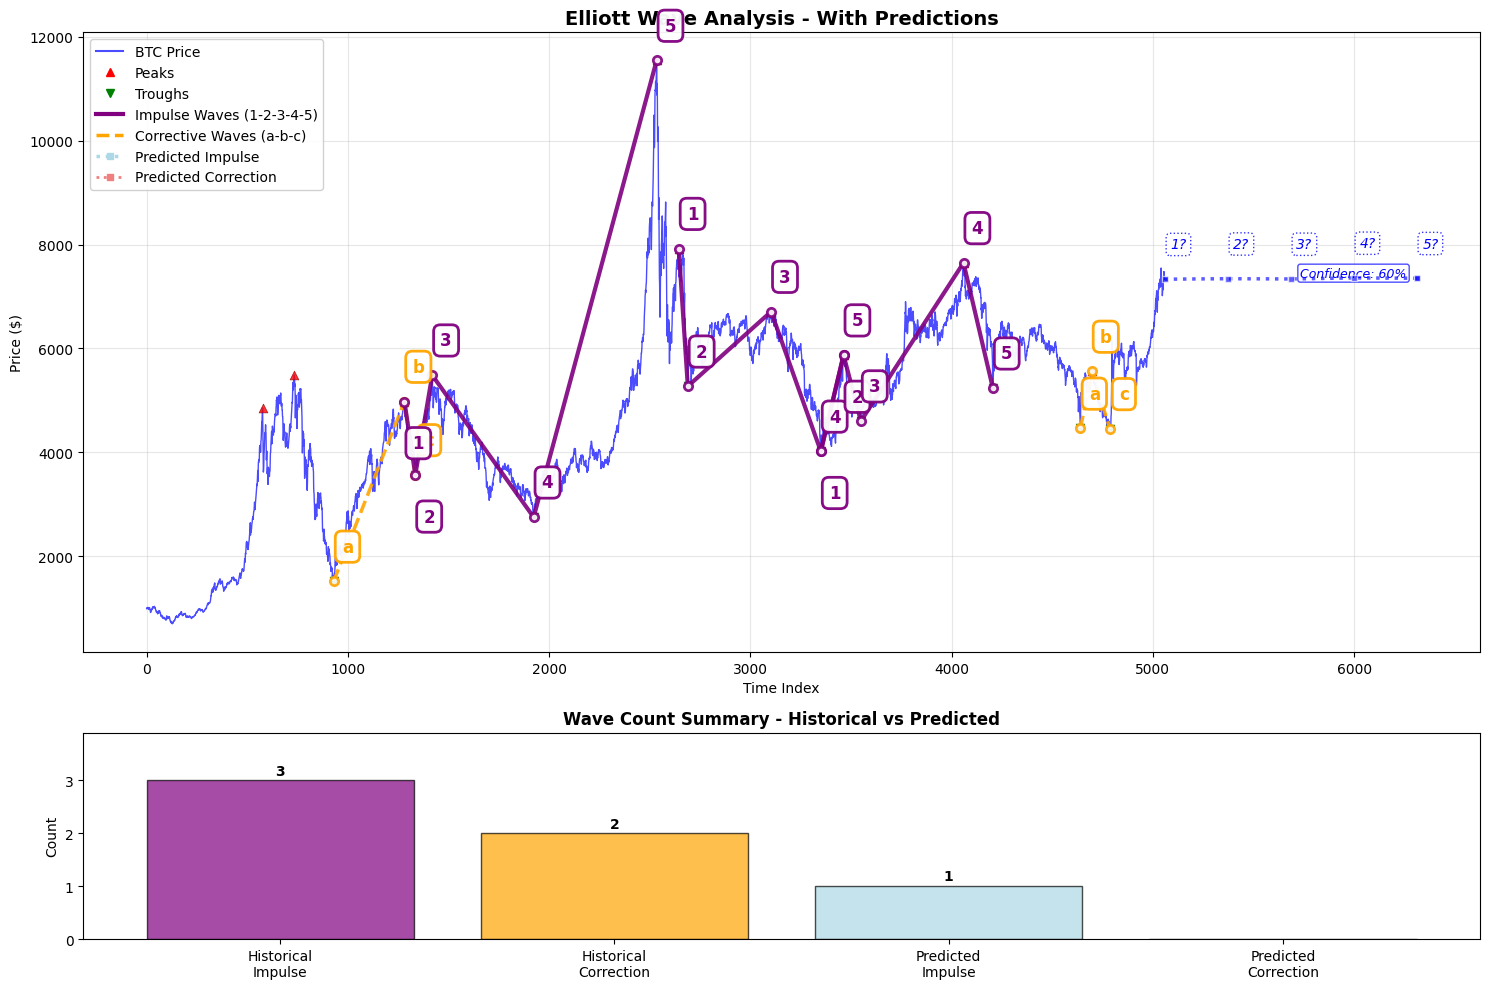


ELLIOTT WAVE ANALYSIS SUMMARY - WITH PREDICTIONS
Total Pivots Found: 19
  - Peaks: 10
  - Troughs: 9

Historical Waves (Non-Overlapping): 5
  - Impulse Waves (1-2-3-4-5): 3
  - Corrective Waves (a-b-c): 2

Predicted Waves: 1
  - Predicted Impulse Waves: 1
  - Predicted Corrective Waves: 0

Note: Overlapping historical waves have been merged, showing only the most significant wave in each time period.
Priority: Impulse waves > Longer duration > Higher strength

IMPULSE WAVES:
----------------------------------------
Wave 1: UP trend
  Range: Index 1281 to 2534 (Length: 1253)
  Price: $4,977.51 → $11,545.89
  Change: +131.96%
  Strength: 1.94

Wave 2: DOWN trend
  Range: Index 2644 to 3463 (Length: 819)
  Price: $7,922.38 → $5,871.56
  Change: -25.89%
  Strength: 1.02

Wave 3: UP trend
  Range: Index 3350 to 4205 (Length: 855)
  Price: $4,018.46 → $5,234.01
  Change: +30.25%
  Strength: 1.65

CORRECTIVE WAVES:
----------------------------------------
Correction 1: UP trend
  Range: Inde

In [7]:
data = pd.read_csv('../data/ZZ500_chan_analysis.csv')
prices = data['close'].values
price_range = np.max(prices) - np.min(prices)

# Create a new detector with merged wave functionality and predictions
print("🔍 Analyzing Elliott Waves with Prediction Capability...")
merged_detector = ElliottWaveDetector(prices)

# Analyze historical waves
merged_detector.analyze_elliott_waves(window=100, prominence=price_range * 0.1)

# Generate predictions and plot everything
print("📈 Generating wave predictions...")
merged_detector.predict_next_wave()

# Plot with predictions enabled (this will also show the advice)
merged_detector.plot_elliott_waves(show_predictions=True)

In [8]:
# Display just the trading advice section
print("Displaying comprehensive trading advice based on all detected waves...")
print()
merged_detector.generate_trading_advice()

Displaying comprehensive trading advice based on all detected waves...


🎯 ELLIOTT WAVE TRADING ADVICE & MARKET OUTLOOK
📈 CURRENT MARKET ANALYSIS:
   Current Price: $7,333.60
   Last Wave: Corrective (down)
   Market Trend: Bearish
   Market Phase: Correction Phase - Potential Continuation or Reversal
   Volatility: Medium

🎯 POSITION ADVICE:
   📈 BULLISH BIAS - Potential upward impulse expected
   • Consider LONG positions on dips
   • Target: Wave 3 completion around $7,357.96
   • Confidence: 60%

🛡️  RISK MANAGEMENT:
   🟡 MODERATE RISK ENVIRONMENT
   • Conservative position sizing recommended
   • Moderate stops: $7,332.48 (Long) / $7,334.72 (Short)
   • Never risk more than 2% of portfolio per trade
   • Use trailing stops once in profit

🎯 ENTRY/EXIT STRATEGIES:
   🚀 IMPULSE BREAKOUT STRATEGY:
   • Enter on breakout above/below current consolidation
   • First target: $7,342.91 (Wave 1)
   • Primary target: $7,357.96 (Wave 3)
   • Take 50% profits at Wave 3, let 50% run to Wave 5